In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import shap

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose

# Scikit-learn for Machine Learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (mean_squared_error, mean_absolute_error, 
                             r2_score, accuracy_score, confusion_matrix, 
                             classification_report, roc_auc_score)
from sklearn.utils import class_weight

# XGBoost Classifier
from xgboost import XGBClassifier

# PrettyTable for Table Display
from prettytable import PrettyTable

In [2]:
# Load the JSON file into a DataFrame
df = pd.read_json('ultimate_data_challenge.json')

df.head(20)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0
8,Winterfell,2,2014-01-21,4.5,1.00,2014-02-01,Android,0.0,False,100.0,4.36,5.0
9,Winterfell,1,2014-01-03,NaN,1.00,2014-01-05,Android,0.0,False,0.0,2.37,5.0


In [3]:
df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [4]:
# General overview of the data
print(df.info())

# Summary statistics for numerical columns
print(df.describe())

# Checking for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None
       trips_in_first_30_days  avg_rating_of_driver     avg_surge  \
coun

In [5]:
# Convert 'signup_date' and 'last_trip_date' to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# Convert 'city' and 'phone' to categorical data type
df['city'] = df['city'].astype('category')
df['phone'] = df['phone'].astype('category')

# Verify the changes
print(df.dtypes)

city                            category
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                           category
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object


In [6]:
# Get the maximum last trip date from the DataFrame
max_last_trip_date = df['last_trip_date'].max()

# Create the 'Active' column based on the condition
df['Active'] = df['last_trip_date'].apply(
    lambda x: (max_last_trip_date - x).days <= 30
)

# Display the updated DataFrame with the new 'Active' column
print(df[['last_trip_date', 'Active']].head())

  last_trip_date  Active
0     2014-06-17    True
1     2014-05-05   False
2     2014-01-07   False
3     2014-06-29    True
4     2014-03-15   False


# Check for missing values

In [7]:
# Checking for missing values
print(df.isnull().sum())

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
Active                       0
dtype: int64


In [8]:


# 1. Check the data types of the DataFrame
print("Data Types of Columns:\n", df.dtypes)

# 2. Convert the 'Active' column to a Boolean type if it's not already
df['Active'] = df['Active'].astype(bool)

# 3. Calculate the percentage of missing values in each column
missing_percentage = df.isnull().mean() * 100

# 4. Select only numeric columns for mean and median calculations
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# 5. Create a summary dictionary for mean and median values based on Active status
summary_data = {
    'Missing Percentage (%)': missing_percentage[numeric_cols]
}

# Calculate means and medians for Active=True and Active=False
for col in numeric_cols:
    mean_active_true = df[df['Active'] == True][col].mean()
    median_active_true = df[df['Active'] == True][col].median()

    mean_active_false = df[df['Active'] == False][col].mean()
    median_active_false = df[df['Active'] == False][col].median()

    summary_data.setdefault('Mean (Active=True)', []).append(f"{mean_active_true:.1f}" if pd.notnull(mean_active_true) else "N/A")
    summary_data.setdefault('Median (Active=True)', []).append(f"{median_active_true:.1f}" if pd.notnull(median_active_true) else "N/A")

    summary_data.setdefault('Mean (Active=False)', []).append(f"{mean_active_false:.1f}" if pd.notnull(mean_active_false) else "N/A")
    summary_data.setdefault('Median (Active=False)', []).append(f"{median_active_false:.1f}" if pd.notnull(median_active_false) else "N/A")

# 6. Create a DataFrame from the summary data
summary_stats = pd.DataFrame(summary_data, index=numeric_cols)

# 7. Create a pretty table for the summary statistics
pretty_table = PrettyTable()

# Add columns to the pretty table
pretty_table.field_names = ["Feature", "Missing Percentage (%)", "Mean (Active=True)", "Median (Active=True)", "Mean (Active=False)", "Median (Active=False)"]

# Add rows to the pretty table
for feature in summary_stats.index:
    pretty_table.add_row([feature] + list(summary_stats.loc[feature]))

# Print the pretty table
print("\nSummary Statistics:\n")
print(pretty_table)

Data Types of Columns:
 city                            category
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                           category
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
Active                              bool
dtype: object

Summary Statistics:

+------------------------+------------------------+--------------------+----------------------+---------------------+-----------------------+
|        Feature         | Missing Percentage (%) | Mean (Active=True) | Median (Active=True) | Mean (Active=False) | Median (Active=False) |
+------------------------+------------------------+--------------------+----------------------+---------------------+------

Percentage of missing values in each column:
 avg_rating_of_driver    16.244
phone                    0.792
avg_rating_by_driver     0.402
dtype: float64


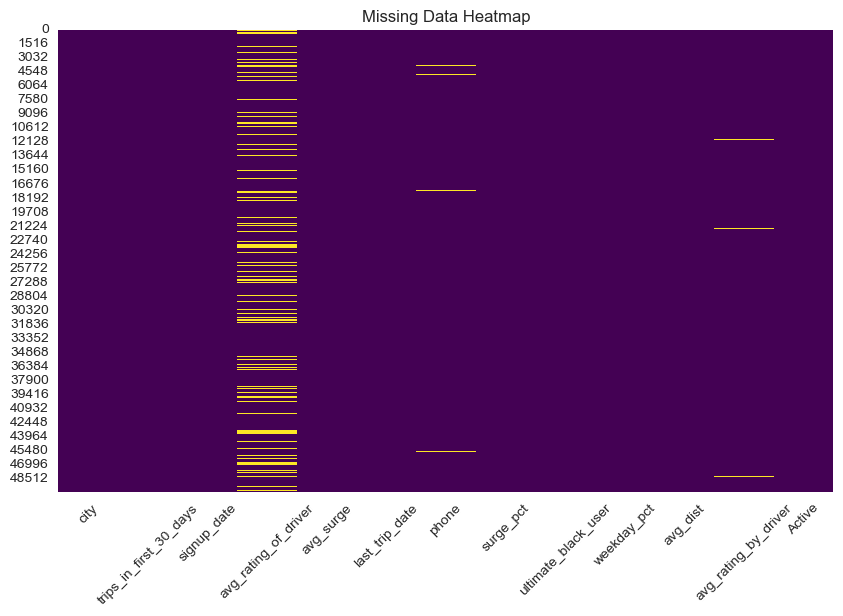


Missing avg_rating_of_driver by city:
                 Missing Count  Missing Percentage (%)
city                                                 
Astapor                  2887               17.460989
King's Landing           1283               12.665350
Winterfell               3952               16.935207


In [9]:
# Check the percentage of missing values in each column
missing_percentage = df.isnull().mean() * 100
print("Percentage of missing values in each column:\n", missing_percentage[missing_percentage > 0])

# Visualize missing data with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')

# Rotate the x-axis labels to 45 degrees
plt.xticks(rotation=45)

plt.show()

# Analyze missing values for avg_rating_of_driver by city
total_entries_by_city = df['city'].value_counts()
avg_rating_missing_by_city = df.groupby('city', observed=True)['avg_rating_of_driver'].apply(lambda x: x.isnull().sum())
avg_rating_missing_percentage = (avg_rating_missing_by_city / total_entries_by_city * 100).fillna(0)

# Combine the counts and percentages into a DataFrame
missing_analysis = pd.DataFrame({
    'Missing Count': avg_rating_missing_by_city,
    'Missing Percentage (%)': avg_rating_missing_percentage
})

print("\nMissing avg_rating_of_driver by city:\n", missing_analysis)

# Cumulative Percentage of Drivers by Last Trip Date

Retention Percentage: 37.61%
Loss Percentage: 62.39%


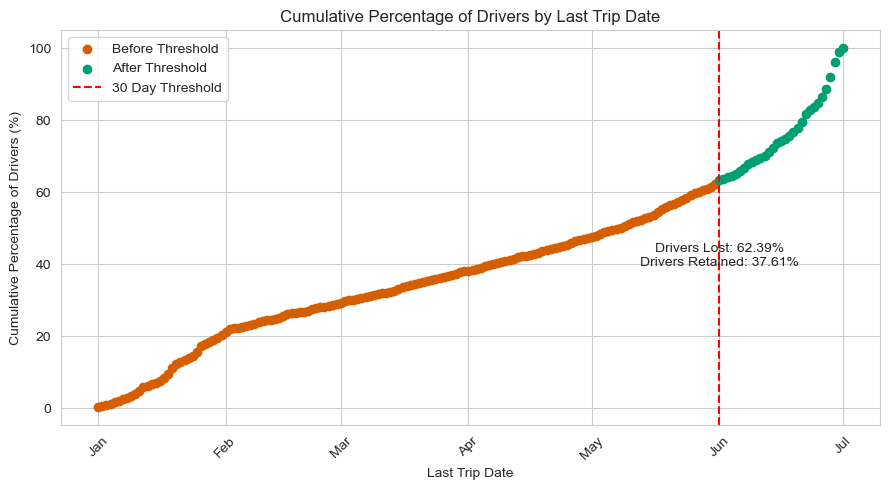

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure last_trip_date is in datetime format
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# Count the number of trips by date
trips_by_date = df.groupby('last_trip_date').size()

# Calculate the cumulative sum of trips
cumulative_trips = trips_by_date.cumsum()

# Calculate the percentage of total trips
cumulative_percentage = (cumulative_trips / cumulative_trips.max()) * 100

# Determine the maximum last trip date
max_date = trips_by_date.index.max()

# Calculate the date 30 days prior to the maximum last trip date
threshold_date = max_date - pd.Timedelta(days=30)

# Calculate retained drivers
retained_drivers = df[df['last_trip_date'] >= threshold_date]
num_retained = retained_drivers.shape[0]
total_drivers = df.shape[0]
num_lost = total_drivers - num_retained  # Calculate lost drivers

# Calculate retention and loss percentages
retention_percentage = (num_retained / total_drivers) * 100
loss_percentage = (num_lost / total_drivers) * 100  # Calculate loss percentage

# Print the retention percentage
print(f'Retention Percentage: {retention_percentage:.2f}%')
print(f'Loss Percentage: {loss_percentage:.2f}%')

# Plotting the cumulative percentage
plt.figure(figsize=(9, 5))

# Scatter points before the threshold
before_threshold = cumulative_percentage[cumulative_percentage.index < threshold_date]
plt.scatter(before_threshold.index, before_threshold, color='#D55E00', label='Before Threshold')  # Dark reddish

# Scatter points after the threshold
after_threshold = cumulative_percentage[cumulative_percentage.index >= threshold_date]
plt.scatter(after_threshold.index, after_threshold, color='#009E73', label='After Threshold')  # Greenish

# Vertical line for the threshold date
plt.axvline(x=threshold_date, color='red', linestyle='--', label='30 Day Threshold')

# Adding the retention and loss information as a text annotation
plt.text(threshold_date, retention_percentage + 2, 
         f'Drivers Lost: {loss_percentage:.2f}%\nDrivers Retained: {retention_percentage:.2f}%', 
          fontsize=10, ha='center')  # Change color to match "After Threshold"

# Formatting the x-axis to show only months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.title('Cumulative Percentage of Drivers by Last Trip Date')
plt.xlabel('Last Trip Date')
plt.ylabel('Cumulative Percentage of Drivers (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

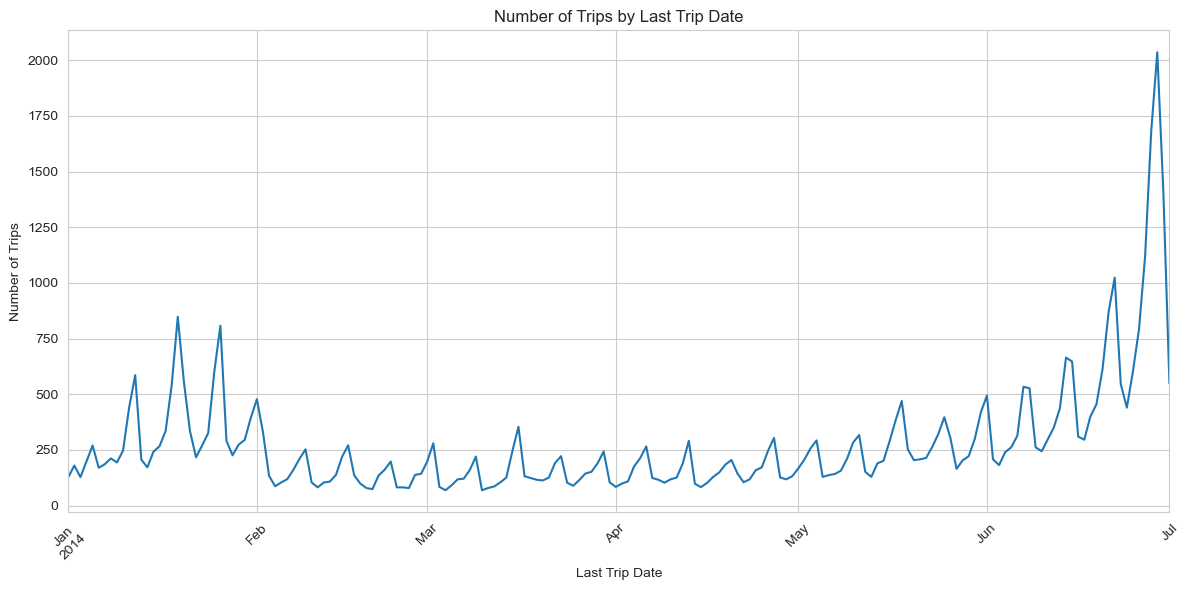

In [11]:
# Count the number of trips by date
trips_by_date = df.groupby('last_trip_date').size()
trips_by_date.plot(figsize=(12, 6))
plt.title('Number of Trips by Last Trip Date')
plt.xlabel('Last Trip Date')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

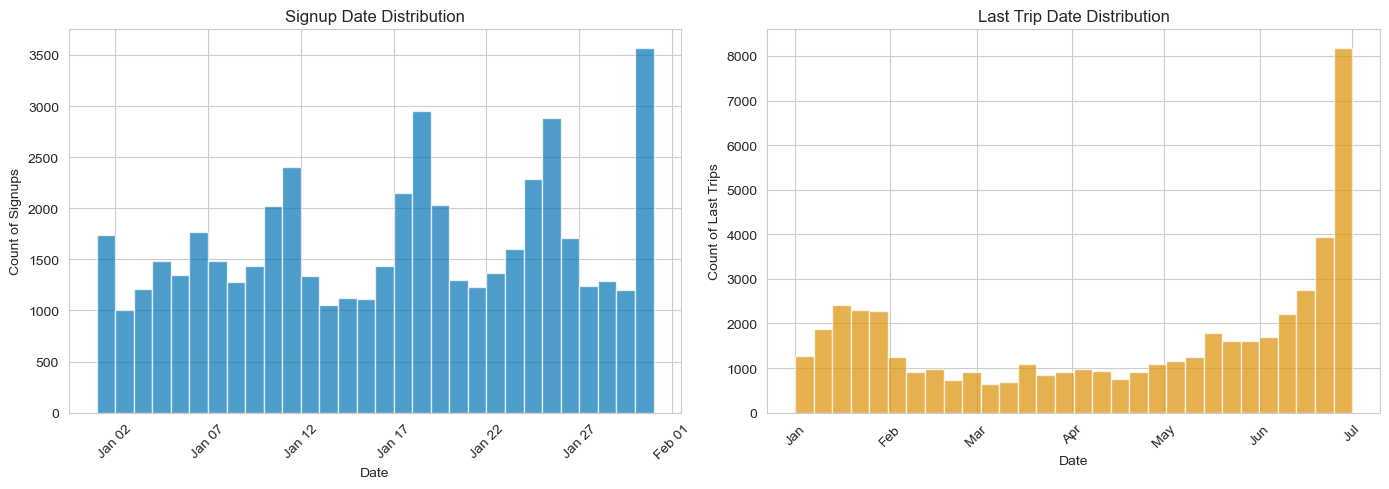

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Set a colorblind-friendly palette
palette = sns.color_palette("colorblind")

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Create a 1x2 grid of subplots

# Plotting the distribution of signup dates
df['signup_date'].hist(ax=axes[0], bins=30, color=palette[0], alpha=0.7)
axes[0].set_title('Signup Date Distribution')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Count of Signups')

# Format x-axis for signup dates
axes[0].xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Set major ticks to be every 5 days
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format the date to show month and day
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)  # Rotate x-axis labels

# Plotting the distribution of last trip dates
df['last_trip_date'].hist(ax=axes[1], bins=30, color=palette[1], alpha=0.7)
axes[1].set_title('Last Trip Date Distribution')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Count of Last Trips')

# Format x-axis for last trip dates
axes[1].xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to be on the months
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Format the date to show month names
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)  # Rotate x-axis labels

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

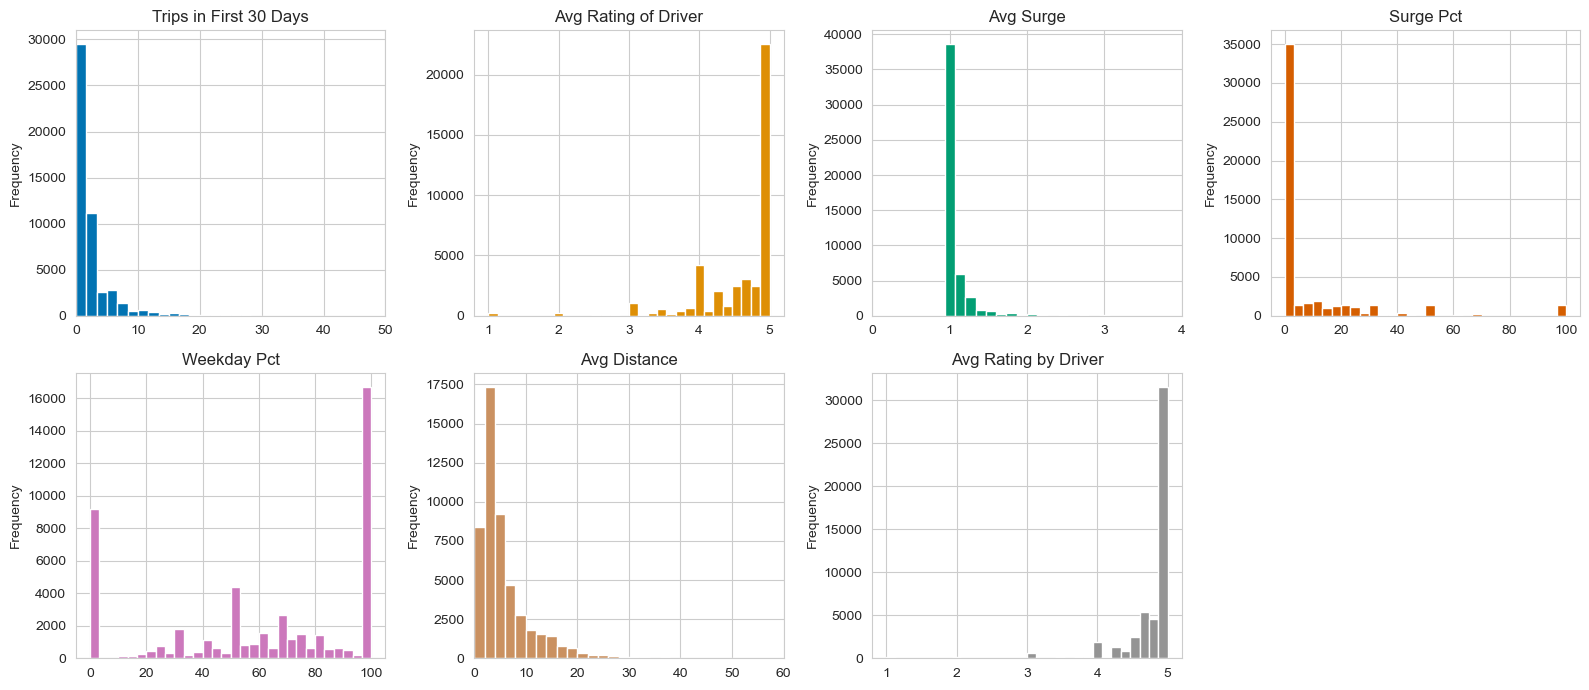

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a colorblind-friendly palette
palette = sns.color_palette("colorblind")

# Plot histograms for all continuous variables with specified ranges
fig, axes = plt.subplots(2, 4, figsize=(16, 7))  # Create a 2x4 grid of subplots

# Plot with custom ranges for specific variables using different colors from the palette
df['trips_in_first_30_days'].plot.hist(ax=axes[0, 0], bins=30, range=(0, 50), color=palette[0])  # First color
axes[0, 0].set_title('Trips in First 30 Days')
axes[0, 0].set_xlim(0, 50)

df['avg_rating_of_driver'].plot.hist(ax=axes[0, 1], bins=30, color=palette[1])  # Second color
axes[0, 1].set_title('Avg Rating of Driver')

df['avg_surge'].plot.hist(ax=axes[0, 2], bins=30, range=(0, 4), color=palette[2])  # Third color
axes[0, 2].set_title('Avg Surge')
axes[0, 2].set_xlim(0, 4)

df['surge_pct'].plot.hist(ax=axes[0, 3], bins=30, color=palette[3])  # Fourth color
axes[0, 3].set_title('Surge Pct')

df['weekday_pct'].plot.hist(ax=axes[1, 0], bins=30, color=palette[4])  # Fifth color
axes[1, 0].set_title('Weekday Pct')

df['avg_dist'].plot.hist(ax=axes[1, 1], bins=30, range=(0, 60), color=palette[5])  # Sixth color
axes[1, 1].set_title('Avg Distance')
axes[1, 1].set_xlim(0, 60)

df['avg_rating_by_driver'].plot.hist(ax=axes[1, 2], bins=30, color=palette[7])  # Seventh color
axes[1, 2].set_title('Avg Rating by Driver')

# Remove the empty plot in the second row
fig.delaxes(axes[1, 3])  # Remove the last subplot

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

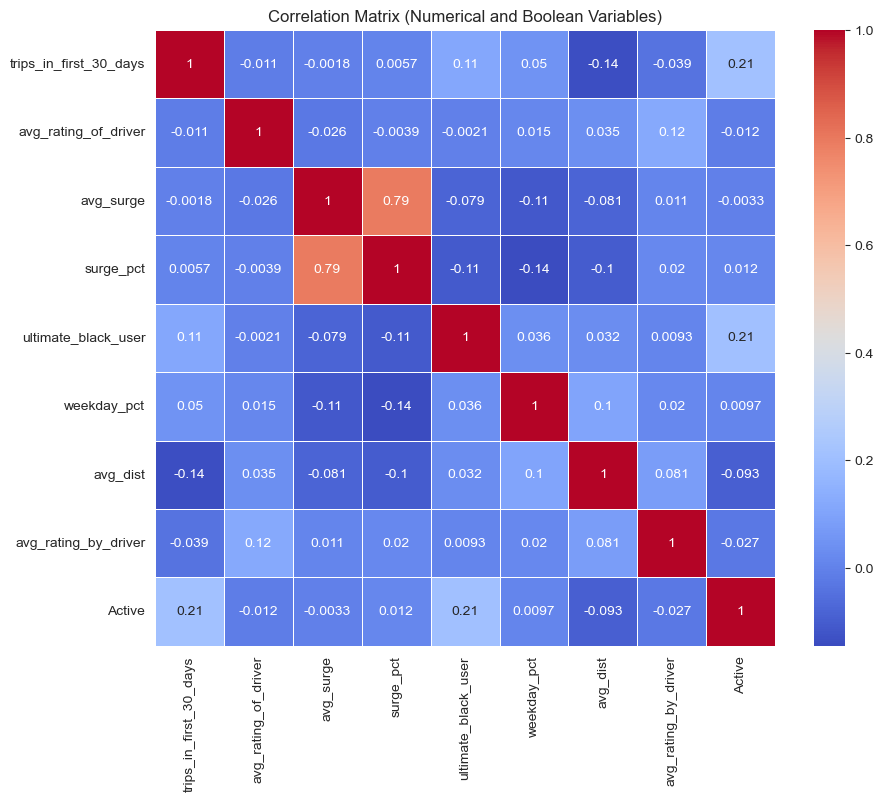

In [14]:
# Selecting numerical and boolean columns
numerical_bool_cols = df.select_dtypes(include=['float64', 'int64', 'bool'])

# Correlation matrix including numerical and boolean variables
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_bool_cols.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix (Numerical and Boolean Variables)')
plt.show()

In [15]:
"""
# Set font scale for larger text
sns.set_context("notebook", font_scale=1.3)  # Adjust font scale as needed

# Create pairplot with hue and transparency
sns.pairplot(df, hue='city', plot_kws={'alpha': 0.3})  # Set alpha for transparency
plt.suptitle('Pair Plot Colored by City', y=1.02)  # Adjust title position
plt.show()"""

'\n# Set font scale for larger text\nsns.set_context("notebook", font_scale=1.3)  # Adjust font scale as needed\n\n# Create pairplot with hue and transparency\nsns.pairplot(df, hue=\'city\', plot_kws={\'alpha\': 0.3})  # Set alpha for transparency\nplt.suptitle(\'Pair Plot Colored by City\', y=1.02)  # Adjust title position\nplt.show()'

# Categorical Features

In [16]:
# Checking the distribution of city
print(df['city'].value_counts())
print('-------')
# Checking the distribution of phone types
print(df['phone'].value_counts())
print('-------')
# Checking the distribution of ultimate_black_user (boolean)
print(df['ultimate_black_user'].value_counts())


city
Winterfell        23336
Astapor           16534
King's Landing    10130
Name: count, dtype: int64
-------
phone
iPhone     34582
Android    15022
Name: count, dtype: int64
-------
ultimate_black_user
False    31146
True     18854
Name: count, dtype: int64


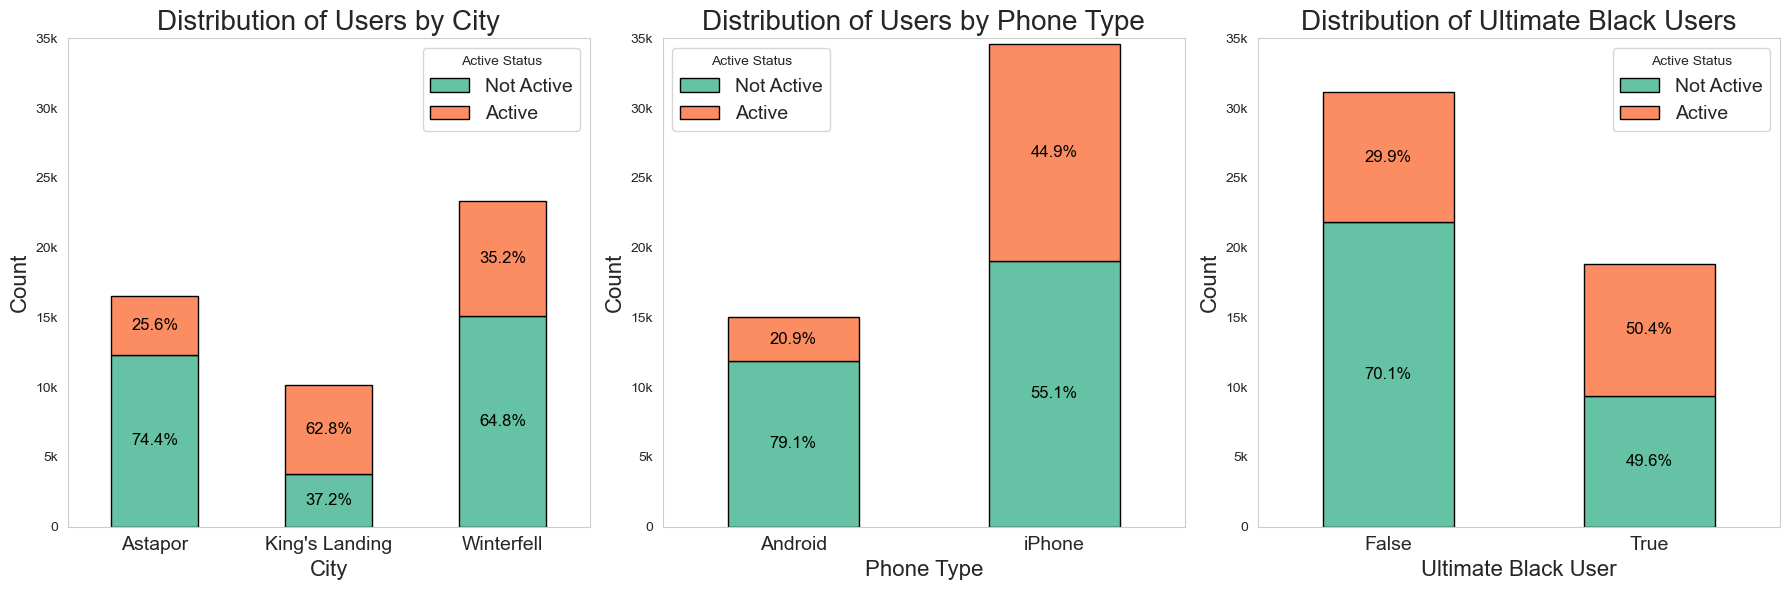

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Create a DataFrame to hold the counts of Active and Not Active users
city_counts = df.groupby(['city', 'Active'], observed=False).size().unstack(fill_value=0)
phone_counts = df.groupby(['phone', 'Active'], observed=False).size().unstack(fill_value=0)
ultimate_black_counts = df.groupby(['ultimate_black_user', 'Active'], observed=False).size().unstack(fill_value=0)

# Set the figure size
plt.figure(figsize=(18, 6))

def thousands_formatter(x, pos):
    """Format ticks to be in thousands."""
    return f'{int(x/1000)}k' if x >= 1000 else str(int(x))

def plot_stacked_bar_with_percentage(counts, title, xlabel, subplot_index, palette):
    # Calculate percentages
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100

    # Plot the stacked bar chart using the specified color palette
    ax = plt.subplot(1, 3, subplot_index)
    counts.plot(kind='bar', stacked=True, ax=ax, color=sns.color_palette(palette), edgecolor='black')

    # Annotate percentages
    for i in range(len(counts)):
        for j in range(len(counts.columns)):
            ax.text(i, counts.iloc[i].cumsum().iloc[j] - counts.iloc[i].iloc[j] / 2,
                    f'{percentages.iloc[i].iloc[j]:.1f}%',
                    ha='center', va='center', color='black', fontsize=12)  # Increase font size for annotations

    # Set title and labels with increased font size
    ax.set_title(title, fontsize=20)  # Increased title font size
    ax.set_xlabel(xlabel, fontsize=16)  # Increased x-axis label font size
    ax.set_ylabel('Count', fontsize=16)  # Increased y-axis label font size
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=14)  # Set x-axis tick labels size
    ax.legend(title='Active Status', fontsize=14, labels=['Not Active', 'Active'])  # Increased legend font size

    # Remove gridlines
    ax.grid(False)

    # Set y-axis limit
    ax.set_ylim(0, 35000)

    # Apply the thousands formatter
    ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Stacked Bar Plot for City using Set2 colors
plot_stacked_bar_with_percentage(city_counts, 'Distribution of Users by City', 'City', 1, 'Set2')

# Stacked Bar Plot for Phone Type using Set2 colors
plot_stacked_bar_with_percentage(phone_counts, 'Distribution of Users by Phone Type', 'Phone Type', 2, 'Set2')

# Stacked Bar Plot for Ultimate Black Users using Set3 colors
plot_stacked_bar_with_percentage(ultimate_black_counts, 'Distribution of Ultimate Black Users', 'Ultimate Black User', 3, 'Set2')

# Adjust layout
plt.tight_layout()
plt.show()

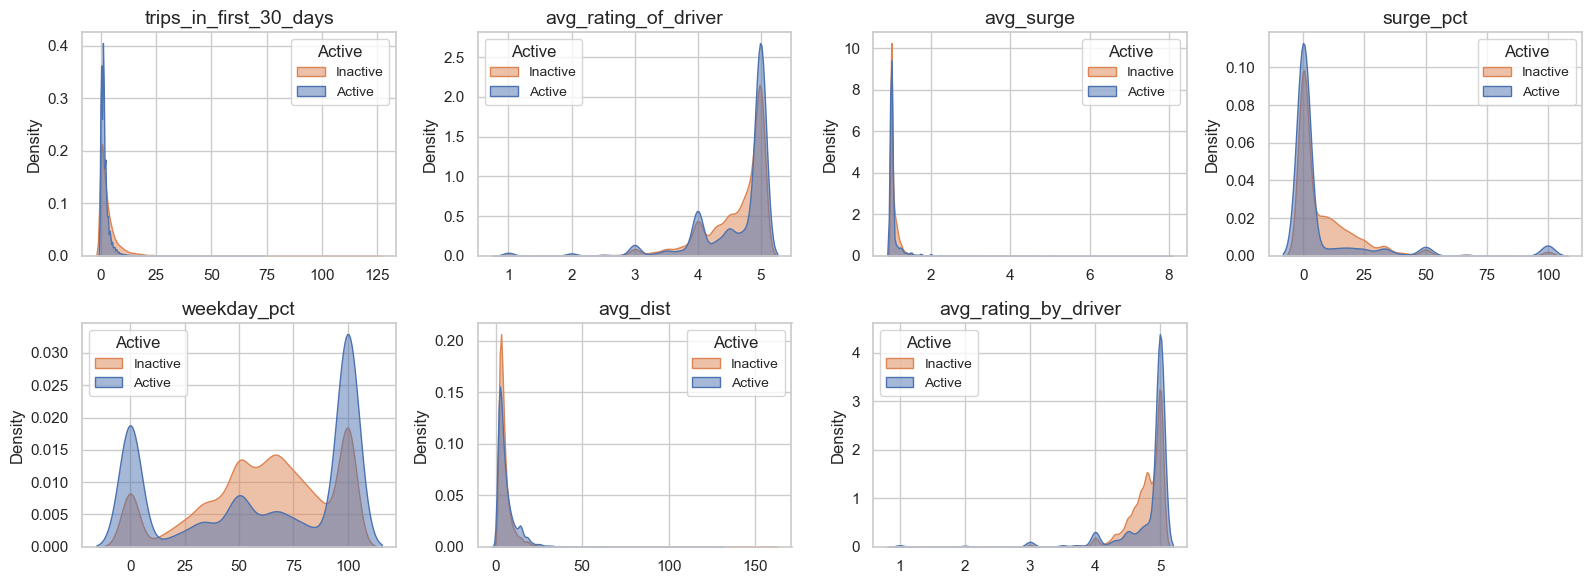

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns from the DataFrame
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure for plotting
plt.figure(figsize=(16, 6))  # Adjusted figure size for better layout

# Loop through each numeric column and create a KDE plot
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 4, i)  # Create a 2-row by 4-column subplot layout
    sns.kdeplot(data=df, x=col, hue='Active', fill=True, common_norm=False, alpha=0.5)

    # Simplified title and labels
    plt.title(col, fontsize=14)
    plt.xlabel('')
    plt.ylabel('Density', fontsize=12)
    plt.legend(title='Active', labels=['Inactive', 'Active'], fontsize=10)

plt.tight_layout()  # Adjusts subplots to fit into the figure area.
plt.show()

# Fill Missing Data

In [19]:
# Fill missing values in 'avg_rating_of_driver' based on 'Active' status
for active_status in [True, False]:
    # Calculate the median rating for the current active status
    median_value = df.loc[df['Active'] == active_status, 'avg_rating_of_driver'].median()

    # Fill missing values in 'avg_rating_of_driver' for the current active status
    df.loc[(df['Active'] == active_status) & (df['avg_rating_of_driver'].isnull()), 'avg_rating_of_driver'] = median_value

# Fill missing values in 'avg_rating_by_driver' similarly
for active_status in [True, False]:
    # Calculate the median avg_rating_by_driver for the current active status
    median_value = df.loc[df['Active'] == active_status, 'avg_rating_by_driver'].median()

    # Fill missing values in 'avg_rating_by_driver' for the current active status
    df.loc[(df['Active'] == active_status) & (df['avg_rating_by_driver'].isnull()), 'avg_rating_by_driver'] = median_value

# Fill missing 'phone' values based on 'Active' status
for active_status in [True, False]:
    # Calculate the mode of 'phone' for the current active status
    mode_value = df.loc[df['Active'] == active_status, 'phone'].mode()

    # If mode value exists, fill missing 'phone' values for the current active status
    if not mode_value.empty:
        df.loc[(df['Active'] == active_status) & (df['phone'].isnull()), 'phone'] = mode_value[0]

# Verify that there are no more null values in the specified columns
print("Null values after filling:")
print("Avg Rating of Driver:", df['avg_rating_of_driver'].isnull().sum())
print("Avg avg_rating_by_driver:", df['avg_rating_by_driver'].isnull().sum())
print("Phone:", df['phone'].isnull().sum())

Null values after filling:
Avg Rating of Driver: 0
Avg avg_rating_by_driver: 0
Phone: 0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  category      
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  category      
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  Active                  50000 non-null  bool  

# Feature Engineering

In [21]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [22]:
# Create a copy of the original DataFrame
df_features = df.copy()


In [23]:
# One hot code the categoricals - city
df_features = pd.get_dummies(df_features, columns=['city'], drop_first=False)

df_features.columns

Index(['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'Active', 'city_Astapor', 'city_King's Landing',
       'city_Winterfell'],
      dtype='object')

In [24]:
# Convert 'signup_date' to datetime
def preprocess_signup_date(df):
    df['signup_date'] = pd.to_datetime(df['signup_date'], format='%Y%m%d')
    df['signup_weekday'] = df['signup_date'].dt.weekday
    df['signup_day_of_month'] = df['signup_date'].dt.day - 1
    return df

# Check if the signup week had a holiday
def add_holiday_feature(df, holidays):
    df['signup_holiday'] = df['signup_date'].isin(holidays).astype(int)
    return df

# Function to create quartiles
def create_quartiles(df, column):
    return pd.qcut(df[column], 10, labels=False, duplicates='drop')

# User activity features
def create_user_activity_features(df):
    quartiles_columns = [
        'avg_dist', 
        'avg_rating_by_driver', 
        'avg_rating_of_driver', 
        'surge_pct', 
        'avg_surge', 
        'trips_in_first_30_days'
    ]
    
    for column in quartiles_columns:
        df[f'{column}_quartile'] = create_quartiles(df, column)

    # Interaction features
    df['total_distance_first_30_days'] = df['avg_dist'] * df['trips_in_first_30_days']
    df['surge_rides_first_30_days'] = df['surge_pct'] * df['trips_in_first_30_days']
    df['engagement'] = (df['trips_in_first_30_days'] / 30 +
                        df['surge_pct'] * df['trips_in_first_30_days'] +
                        df['avg_dist'])
    return df

# Additional features for user engagement and activity analysis
def add_engagement_features(df):
    df['active_days_first_month'] = df['trips_in_first_30_days'].apply(lambda x: min(x, 30))
    df['engagement_score'] = (df['trips_in_first_30_days'] * 0.5 +
                               df['surge_pct'] * 0.3 +
                               df['avg_dist'] * 0.2)
    df['burnout_indicator'] = (df['trips_in_first_30_days'] < 5).astype(int)  # Example threshold
    df['active_days_ratio'] = df['trips_in_first_30_days'] / 30
    df['total_engagement_days'] = df['trips_in_first_30_days'] + df['active_days_first_month']
    
    # For activity level change
    df['activity_level_change'] = df['trips_in_first_30_days'].rolling(window=7).mean().fillna(0)
    df['surge_interaction_ratio'] = (df['surge_pct'] * df['trips_in_first_30_days']) / (df['trips_in_first_30_days'] + 1)

    # Weekend Engagement
    df['weekend_trips'] = df['trips_in_first_30_days'] * df['signup_weekday'].apply(lambda x: 1 if x in [5, 6] else 0)

    # Average Trip Duration
    avg_speed = 30  # Example speed in km/h
    df['avg_trip_duration'] = df['avg_dist'] / avg_speed
    
    # Trip Density
    df['trip_density'] = df['trips_in_first_30_days'] / 30

    return df

# Function to calculate weekday and weekend trips
def add_weekend_weekday_trips(df):
    df['weekday_trips'] = (df['weekday_pct'] / 100) * df['trips_in_first_30_days']
    df['weekend_trips'] = df['trips_in_first_30_days'] - df['weekday_trips']
    
    # Convert to integers if you want whole trips
    df['weekday_trips'] = df['weekday_trips'].round().astype(int)
    df['weekend_trips'] = df['weekend_trips'].round().astype(int)
    
    return df

# Function to add boolean features
def add_boolean_features(df):
    df['more_than_0_trips'] = (df['trips_in_first_30_days'] > 0).astype(int)
    df['not_5_avg_rating_of_driver'] = (df['avg_rating_of_driver'] < 5).astype(int)
    df['avg_surge_greater_than_1'] = (df['avg_surge'] > 1.00).astype(int)
    df['surge_pct_greater_than_0'] = (df['surge_pct'] > 0.0).astype(int)
    df['not_5_avg_rating_by_driver'] = (df['avg_rating_by_driver'] < 5).astype(int)
    df['not_1_or_100_weekday_pct'] = ((df['weekday_pct'] != 1) & (df['weekday_pct'] != 100)).astype(int)
    df['iphone'] = (df['phone'] == 'iPhone').astype(int)  # Assuming 'phone' is the column for device type

    return df

# Main processing function
def process_features(df):
    # Define holidays
    holidays = pd.to_datetime(['2014-01-01', '2014-02-01'])  # Update with actual holiday dates

    # Apply preprocessing functions
    df = preprocess_signup_date(df)
    df = add_holiday_feature(df, holidays)
    df = create_user_activity_features(df)
    df = add_engagement_features(df)
    df = add_weekend_weekday_trips(df)  # Add the new trips feature
    df = add_boolean_features(df)  # Add new boolean features
    
    # Drop the phone column
    df = df.drop(columns=['phone'], errors='ignore')  # Use errors='ignore' to avoid errors if 'phone' doesn't exist

    return df

# Execute feature processing
df_features = process_features(df_features)

# Display the resulting DataFrame
print(df_features)

       trips_in_first_30_days signup_date  avg_rating_of_driver  avg_surge  \
0                           4  2014-01-25                   4.7       1.10   
1                           0  2014-01-29                   5.0       1.00   
2                           3  2014-01-06                   4.3       1.00   
3                           9  2014-01-10                   4.6       1.14   
4                          14  2014-01-27                   4.4       1.19   
...                       ...         ...                   ...        ...   
49995                       0  2014-01-25                   5.0       1.00   
49996                       1  2014-01-24                   5.0       1.00   
49997                       0  2014-01-31                   5.0       1.00   
49998                       2  2014-01-14                   3.0       1.00   
49999                       0  2014-01-18                   5.0       1.00   

      last_trip_date  surge_pct  ultimate_black_user  weekday_p

In [25]:
df_features.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,...,avg_trip_duration,trip_density,weekday_trips,more_than_0_trips,not_5_avg_rating_of_driver,avg_surge_greater_than_1,surge_pct_greater_than_0,not_5_avg_rating_by_driver,not_1_or_100_weekday_pct,iphone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,...,0.122333,0.133333,2,1,1,1,1,0,1,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,...,0.275333,0.000000,0,0,0,0,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,...,0.025667,0.100000,3,1,1,0,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,...,0.078667,0.300000,7,1,1,1,1,1,1,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,...,0.104333,0.466667,12,1,1,1,1,1,1,0


In [26]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 44 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   trips_in_first_30_days           50000 non-null  int64         
 1   signup_date                      50000 non-null  datetime64[ns]
 2   avg_rating_of_driver             50000 non-null  float64       
 3   avg_surge                        50000 non-null  float64       
 4   last_trip_date                   50000 non-null  datetime64[ns]
 5   surge_pct                        50000 non-null  float64       
 6   ultimate_black_user              50000 non-null  bool          
 7   weekday_pct                      50000 non-null  float64       
 8   avg_dist                         50000 non-null  float64       
 9   avg_rating_by_driver             50000 non-null  float64       
 10  Active                           50000 non-null  bool     

In [27]:
# Calculate correlation with respect to 'Active'
correlation_with_active = df_features.corr()['Active'].sort_values(ascending=False)

# Display the correlation results
print(correlation_with_active)

Active                             1.000000
last_trip_date                     0.780837
not_5_avg_rating_by_driver         0.322103
not_5_avg_rating_of_driver         0.317015
surge_pct_greater_than_0           0.287224
avg_surge_greater_than_1           0.285393
city_King's Landing                0.262284
trips_in_first_30_days_quartile    0.253147
not_1_or_100_weekday_pct           0.250270
iphone                             0.225464
active_days_first_month            0.219540
total_engagement_days              0.215806
trip_density                       0.210463
active_days_ratio                  0.210463
trips_in_first_30_days             0.210463
ultimate_black_user                0.205002
weekday_trips                      0.189770
weekend_trips                      0.187126
avg_surge_quartile                 0.147738
surge_pct_quartile                 0.137969
total_distance_first_30_days       0.137564
surge_rides_first_30_days          0.130645
engagement                      

Many of the newly created features are strongly correlated with our target variable

# Log feature investigation

In [28]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# Let's first define a function to compute the log, delta, and correlation values
def compute_log_delta_correlations(df, target_column):
    log_delta_correlations = {}

    # Loop through each column in the DataFrame
    for column in df.select_dtypes(include=[np.number]).columns:
        if column != target_column:  # Exclude the target variable itself
            # Calculate log values (adding a small constant to avoid log(0))
            log_column = np.log1p(df[column])  # log1p is used for log(1 + x) to avoid log(0)

            # Calculate correlations with respect to the target variable
            regular_corr = df[column].corr(df[target_column])
            log_corr = log_column.corr(df[target_column])

            # Calculate delta as absolute difference between regular and log correlations
            delta_corr = abs(regular_corr - log_corr)

            # Store the results
            log_delta_correlations[column] = {
                'Regular': regular_corr,
                'Log': log_corr,
                'Delta': delta_corr
            }

    # Convert to DataFrame for better display
    correlation_df = pd.DataFrame(log_delta_correlations).T
    correlation_df.columns = ['Regular Correlation', 'Log Correlation', 'Delta Correlation']

    # Select a limited number of columns to display
    correlation_df = correlation_df[['Regular Correlation', 'Log Correlation', 'Delta Correlation']]

    # Sort by Delta Correlation in descending order
    correlation_df = correlation_df.sort_values(by='Delta Correlation', ascending=False)

    return correlation_df

# Assuming your target variable is 'Active'
correlation_results = compute_log_delta_correlations(df_features, 'Active')

# Print the results as a compact table with two decimal places
print(tabulate(correlation_results, headers='keys', tablefmt='plain', floatfmt=".2f", stralign='center'))

                                   Regular Correlation    Log Correlation    Delta Correlation
           surge_pct                              0.01               0.19                 0.18
    surge_interaction_ratio                       0.04               0.19                 0.14
          weekday_pct                             0.01               0.15                 0.14
   surge_rides_first_30_days                      0.13               0.23                 0.10
       engagement_score                           0.06               0.16                 0.10
 avg_rating_by_driver_quartile                   -0.20              -0.14                 0.06
          engagement                              0.12               0.18                 0.06
       avg_dist_quartile                         -0.04               0.02                 0.06
 avg_rating_of_driver_quartile                   -0.13              -0.08                 0.05
      surge_pct_quartile                          

In [29]:
import numpy as np

# Specify the columns to log-transform
columns_to_transform = [
    'surge_pct',
    'weekday_pct',
    'surge_rides_first_30_days',
    'engagement_score', 
    'surge_interaction_ratio'
    
]

# Loop through each specified column and add the log-transformed version to the DataFrame
for column in columns_to_transform:
    if column in df_features.columns:  # Check if the column exists
        df_features[f'log_{column}'] = np.log1p(df_features[column])  # Adding log-transformed column

# Display the updated DataFrame
print(df_features.head())

   trips_in_first_30_days signup_date  avg_rating_of_driver  avg_surge  \
0                       4  2014-01-25                   4.7       1.10   
1                       0  2014-01-29                   5.0       1.00   
2                       3  2014-01-06                   4.3       1.00   
3                       9  2014-01-10                   4.6       1.14   
4                      14  2014-01-27                   4.4       1.19   

  last_trip_date  surge_pct  ultimate_black_user  weekday_pct  avg_dist  \
0     2014-06-17       15.4                 True         46.2      3.67   
1     2014-05-05        0.0                False         50.0      8.26   
2     2014-01-07        0.0                False        100.0      0.77   
3     2014-06-29       20.0                 True         80.0      2.36   
4     2014-03-15       11.8                False         82.4      3.13   

   avg_rating_by_driver  ...  avg_surge_greater_than_1  \
0                   5.0  ...                  

# Modeling

In [30]:
# Create a copy of df_features and rename it to df_modeling
df_modeling = df_features.copy()

In [31]:
# Drop the 'last_trip_date' column from df_modeling
df_modeling = df_modeling.drop(columns=['last_trip_date'])

# Verify that the column has been dropped
print(df_modeling.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   trips_in_first_30_days           50000 non-null  int64         
 1   signup_date                      50000 non-null  datetime64[ns]
 2   avg_rating_of_driver             50000 non-null  float64       
 3   avg_surge                        50000 non-null  float64       
 4   surge_pct                        50000 non-null  float64       
 5   ultimate_black_user              50000 non-null  bool          
 6   weekday_pct                      50000 non-null  float64       
 7   avg_dist                         50000 non-null  float64       
 8   avg_rating_by_driver             50000 non-null  float64       
 9   Active                           50000 non-null  bool          
 10  city_Astapor                     50000 non-null  bool     

In [32]:
# 1. Convert boolean columns to integers
bool_cols = df_modeling.select_dtypes(include=['bool']).columns
df_modeling[bool_cols] = df_modeling[bool_cols].astype(int)

# 2. Convert datetime columns to numerical format (you can customize this as needed)
datetime_cols = df_modeling.select_dtypes(include=['datetime64[ns]']).columns
for col in datetime_cols:
    # Option 1: Convert to timestamp (seconds since epoch)
    df_modeling[col] = df_modeling[col].astype(int) / 10**9  # Convert nanoseconds to seconds

# 3. Check the data types and ensure everything is numeric
print(df_modeling.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   trips_in_first_30_days           50000 non-null  int64  
 1   signup_date                      50000 non-null  float64
 2   avg_rating_of_driver             50000 non-null  float64
 3   avg_surge                        50000 non-null  float64
 4   surge_pct                        50000 non-null  float64
 5   ultimate_black_user              50000 non-null  int64  
 6   weekday_pct                      50000 non-null  float64
 7   avg_dist                         50000 non-null  float64
 8   avg_rating_by_driver             50000 non-null  float64
 9   Active                           50000 non-null  int64  
 10  city_Astapor                     50000 non-null  int64  
 11  city_King's Landing              50000 non-null  int64  
 12  city_Winterfell   

# Modeling - Mean Regressor

In [33]:

# Select features and target
X = df_modeling.drop(columns=['Active'])  # Drop the target variable
y = df_modeling['Active'].astype(int)  # Convert target to integer

# Convert categorical columns to numerical
X = pd.get_dummies(X, drop_first=False)  # Convert categorical variables to dummy/indicator variables

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Mean Regressor
mean_pred = y_train.mean()
mean_predictions = [mean_pred] * len(y_test)

# Convert mean predictions to binary outcomes for accuracy metrics
mean_binary_predictions = [1 if pred > 0.5 else 0 for pred in mean_predictions]

# Calculate accuracy and other metrics for the Mean Regressor
mean_accuracy = accuracy_score(y_test, mean_binary_predictions)
mean_conf_matrix = confusion_matrix(y_test, mean_binary_predictions)
mean_class_report = classification_report(y_test, mean_binary_predictions, zero_division=0)  # Set zero_division=0
mean_roc_auc = roc_auc_score(y_test, mean_binary_predictions)

# Print Mean Regressor performance metrics
print("\nMean Regressor Performance:")
print("Accuracy:", mean_accuracy)
print("Confusion Matrix:\n", mean_conf_matrix)
print("Classification Report:\n", mean_class_report)
print("ROC-AUC Score:", mean_roc_auc)


Mean Regressor Performance:
Accuracy: 0.6239
Confusion Matrix:
 [[6239    0]
 [3761    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77      6239
           1       0.00      0.00      0.00      3761

    accuracy                           0.62     10000
   macro avg       0.31      0.50      0.38     10000
weighted avg       0.39      0.62      0.48     10000

ROC-AUC Score: 0.5


# Modeling - Logistic Regression

In [34]:


# Sample data setup (assuming df_modeling is defined)
X = df_modeling.drop(columns=['Active'])  # Drop the target variable
y = df_modeling['Active'].astype(int)  # Convert target to integer

# Convert categorical columns to numerical
X = pd.get_dummies(X, drop_first=False)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculate class weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}  # Adjust weights based on your classes

# Set up the hyperparameter distribution for Logistic Regression
param_dist = {
    'C': np.logspace(-4, 4, 20),  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Regularization type
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],  # Solvers
    'max_iter': [1000, 2000, 3000],  # Maximum number of iterations
    'class_weight': [class_weights, 'balanced', None]  # Include class weights
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    LogisticRegression(),
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings to sample
    cv=5,  # Number of folds in cross-validation
    scoring='accuracy',  # Scoring metric
    verbose=1,  # Verbosity
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Get the best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

# Predict on the test set
y_pred = best_model.predict(X_test_scaled)

# Evaluate the model and update naming conventions
logreg_accuracy = accuracy_score(y_test, y_pred)
logreg_conf_matrix = confusion_matrix(y_test, y_pred)
logreg_class_report = classification_report(y_test, y_pred)
logreg_roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test_scaled)[:, 1])

# Output the results with updated metrics names
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)
print("Logistic Regression Accuracy:", logreg_accuracy)
print("Logistic Regression Confusion Matrix:\n", logreg_conf_matrix)
print("Logistic Regression Classification Report:\n", logreg_class_report)
print("Logistic Regression ROC-AUC Score:", logreg_roc_auc)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
25 fits 

Best Parameters: {'solver': 'newton-cg', 'penalty': None, 'max_iter': 3000, 'class_weight': None, 'C': 0.012742749857031334}
Best Cross-Validation Score: 0.790125
Logistic Regression Accuracy: 0.7883
Logistic Regression Confusion Matrix:
 [[5404  835]
 [1282 2479]]
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84      6239
           1       0.75      0.66      0.70      3761

    accuracy                           0.79     10000
   macro avg       0.78      0.76      0.77     10000
weighted avg       0.79      0.79      0.79     10000

Logistic Regression ROC-AUC Score: 0.8609602461619342


# Modeling - Random Forest

In [35]:
X = df_modeling.drop(columns=['Active'])  # Drop the target variable
y = df_modeling['Active'].astype(int)  # Convert target to integer

# Convert categorical columns to numerical
X = pd.get_dummies(X, drop_first=False)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculate class weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}  # Adjust weights based on your classes

# Set up the hyperparameter distribution for Random Forest
param_dist = {
    'n_estimators': np.arange(2, 1001, 100),  # Number of trees (100 to 1000)
    'max_depth': [None] + list(np.arange(2, 51, 5)),  # Maximum depth of the trees
    'min_samples_split': np.arange(2, 11, 1),  # Minimum samples required to split a node (2 to 10)
    'min_samples_leaf': np.arange(1, 11, 1),  # Minimum number of samples required at a leaf node (1 to 10)
    'max_features': ['sqrt', 'log2', None],  # Update to use 'sqrt' instead of 'auto'
    'class_weight': [class_weights, 'balanced', None]  # Include class weights in hyperparameter tuning
}

# Set up Randomized Search
random_search = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings to sample
    cv=5,  # Number of folds in cross-validation
    scoring='accuracy',  # Scoring metric
    verbose=3,  # Verbosity
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit Randomized Search
random_search.fit(X_train_scaled, y_train)

# Best parameters and score
best_rf_params = random_search.best_params_
best_rf_score = random_search.best_score_

# Fit the model with the best parameters
best_rf = random_search.best_estimator_
y_rf_pred = best_rf.predict(X_test_scaled)

# Evaluate the model and update naming conventions
rf_accuracy = accuracy_score(y_test, y_rf_pred)
rf_conf_matrix = confusion_matrix(y_test, y_rf_pred)
rf_class_report = classification_report(y_test, y_rf_pred)
rf_roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test_scaled)[:, 1])

# Output the evaluation metrics with updated metric names
print("Best Parameters:", best_rf_params)
print("Best Cross-Validation Score:", best_rf_score)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Confusion Matrix:\n", rf_conf_matrix)
print("Random Forest Classification Report:\n", rf_class_report)
print("Random Forest ROC-AUC Score:", rf_roc_auc)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 2/5] END class_weight={0: 0.8013783707977722, 1: 1.3295220368277605}, max_depth=22, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=502;, score=0.793 total time= 4.0min
[CV 1/5] END class_weight=None, max_depth=47, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=802;, score=0.802 total time=  50.8s


/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 4/5] END class_weight={0: 0.8013783707977722, 1: 1.3295220368277605}, max_depth=22, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=502;, score=0.800 total time= 4.1min
[CV 2/5] END class_weight=None, max_depth=47, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=802;, score=0.803 total time=  50.5s
[CV 1/5] END class_weight={0: 0.8013783707977722, 1: 1.3295220368277605}, max_depth=22, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=502;, score=0.799 total time= 4.1min
[CV 3/5] END class_weight=None, max_depth=47, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=802;, score=0.802 total time=  51.5s
[CV 1/5] END class_weight={0: 0.8013783707977722, 1: 1.3295220368277605}, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=7, n_estimators=2;, score=0.763 total time=   0.2s
[CV 5/5] END class_weight={0: 0.8013783707977722, 1: 1.3295220368277605}, max_depth=None, max

# Modeling - XGBoost

In [36]:
# Sample data setup (assuming df_modeling is defined)
X = df_modeling.drop(columns=['Active'])  # Drop the target variable
y = df_modeling['Active'].astype(int)  # Convert target to integer

# Convert categorical columns to numerical
X = pd.get_dummies(X, drop_first=False)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features (optional for XGBoost, but can be useful)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the XGBoost model
xgb = XGBClassifier(eval_metric='logloss')

# Set up the hyperparameter distribution for Randomized Search
param_dist = {
    'n_estimators': np.arange(2, 2000, 50),  # Values from 2 to 2000 in steps of 50
    'max_depth': np.arange(2, 100),  # Maximum depth of trees (2 to 99)
    'learning_rate': np.arange(0.001, 1.01, 0.05),  # Learning rates from 0.001 to 1 in steps of 0.05
    'subsample': np.arange(0.3, 1.05, 0.1),  # Subsample ratio of the training instances
    'colsample_bytree': np.arange(0.3, 1.05, 0.1),  # Subsample ratio of columns for each tree
    'gamma': np.arange(0, 6, 0.5),  # Minimum loss reduction required to make a further partition
}

# Set up Randomized Search
random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings to sample
    cv=5,  # Number of folds in cross-validation
    scoring='accuracy',  # Scoring metric
    verbose=2,  # Verbosity
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit Randomized Search
print("Starting Randomized Search...")
random_search.fit(X_train_scaled, y_train)

# Get the best model and parameters
best_xgb_model = random_search.best_estimator_
best_xgb_params = random_search.best_params_
best_xgb_score = random_search.best_score_

# Make predictions using the best estimator
print("Making predictions with the best estimator...")
y_xgb_pred = best_xgb_model.predict(X_test_scaled)

# Evaluate the model using classification metrics
xgb_accuracy = accuracy_score(y_test, y_xgb_pred)
xgb_conf_matrix = confusion_matrix(y_test, y_xgb_pred)
xgb_class_report = classification_report(y_test, y_xgb_pred)

# Calculate probabilities for ROC-AUC score
y_xgb_pred_proba = best_xgb_model.predict_proba(X_test_scaled)[:, 1]
xgb_roc_auc = roc_auc_score(y_test, y_xgb_pred_proba)

# Output the evaluation metrics with updated naming conventions
print("\nBest Parameters:", best_xgb_params)
print("Best Cross-Validation Score:", best_xgb_score)
print("XGBoost Accuracy:", xgb_accuracy)
print("XGBoost Confusion Matrix:\n", xgb_conf_matrix)
print("XGBoost Classification Report:\n", xgb_class_report)
print("XGBoost ROC-AUC Score:", xgb_roc_auc)

Starting Randomized Search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 2/5] END class_weight=balanced, max_depth=22, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=102;, score=0.797 total time=   6.9s
[CV 1/5] END class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=7, n_estimators=302;, score=0.803 total time=  18.9s
[CV 2/5] END class_weight={0: 0.8013783707977722, 1: 1.3295220368277605}, max_depth=22, max_features=None, min_samples_leaf=9, min_samples_split=2, n_estimators=302;, score=0.793 total time= 2.2min
[CV 5/5] END class_weight={0: 0.8013783707977722, 1: 1.3295220368277605}, max_depth=None, max_features=sqrt, min_samples_leaf=9, min_samples_split=6, n_estimators=902;, score=0.804 total time= 1.0min
[CV 2/5] END class_weight={0: 0.8013783707977722, 1: 1.3295220368277605}, max_depth=2, max_features=None, min_samples_leaf=10, min_samples_split=2, n_estimators=102;, score=0.723 total time= 

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 5/5] END class_weight={0: 0.8013783707977722, 1: 1.3295220368277605}, max_depth=22, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=502;, score=0.801 total time= 4.0min
[CV 4/5] END class_weight=balanced, max_depth=7, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=402;, score=0.785 total time= 1.7min
[CV 2/5] END class_weight=None, max_depth=7, max_features=None, min_samples_leaf=7, min_samples_split=10, n_estimators=102;, score=0.791 total time=  27.9s
[CV 1/5] END class_weight=None, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2;, score=0.768 total time=   0.1s
[CV 2/5] END class_weight=None, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2;, score=0.773 total time=   0.1s
[CV 3/5] END class_weight=None, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2;, score=0.777 total time=   0.1s
[CV 4/5] END class_weight=No


Top Features by Importance:
                             Feature  Importance
36       not_5_avg_rating_of_driver    0.132434
39       not_5_avg_rating_by_driver    0.087883
10              city_King's Landing    0.081263
16    avg_rating_by_driver_quartile    0.072269
8              avg_rating_by_driver    0.056769
17    avg_rating_of_driver_quartile    0.056588
2              avg_rating_of_driver    0.045429
37         avg_surge_greater_than_1    0.042370
38         surge_pct_greater_than_0    0.040323
5               ultimate_black_user    0.036968
41                           iphone    0.032404
40         not_1_or_100_weekday_pct    0.020924
11                  city_Winterfell    0.020844
42                    log_surge_pct    0.016275
4                         surge_pct    0.015816
9                      city_Astapor    0.015548
3                         avg_surge    0.012768
6                       weekday_pct    0.012099
27                active_days_ratio    0.012026
43        

/var/folders/mn/5t8x6ck57719dt2pg7h0_xl40000gn/T/ipykernel_97618/173244698.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature', palette='viridis')


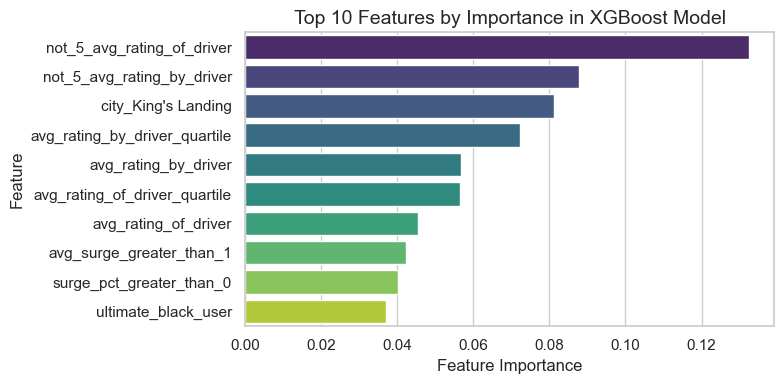

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Continue from your existing code...

# Step 1: Get the feature importances from the XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Step 2: Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Column names from the training data
    'Importance': feature_importances
})

# Step 3: Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print("\nTop Features by Importance:\n", feature_importance_df)

# Optional: Visualize feature importance
plt.figure(figsize=(8, 4))

# Step 4: Visualize the top 10 features by importance
sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Features by Importance in XGBoost Model', fontsize=14)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Step 5: Tighten the layout and display the plot
plt.tight_layout()
plt.show()

# Model Comparison

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Function to print classification report and extract specific F1-scores
def print_classification_report_and_extract_f1(report, label):
    print(f"\nClassification Report for {label}:\n")
    print(report)
    
    lines = report.split("\n")
    f1_scores = []
    
    # Parse each line to get F1-scores for each class
    for line in lines[2:-5]:  # Skip the first two header lines and last lines with averages
        tokens = line.split()
        if len(tokens) >= 4:
            f1_scores.append((tokens[0], tokens[-2]))  # Class label and F1-score (2nd last element)
    
    # Extract overall avg F1-scores
    macro_avg_f1 = lines[-4].split()[-2]  # Macro avg F1
    weighted_avg_f1 = lines[-3].split()[-2]  # Weighted avg F1
    
    print(f"F1-scores for each class: {f1_scores}")
    print(f"Macro average F1-score: {macro_avg_f1}")
    print(f"Weighted average F1-score: {weighted_avg_f1}")
    
    return weighted_avg_f1  # You can return another score as needed

# Extract F1-scores and print out full classification report for each model
rf_f1_score = print_classification_report_and_extract_f1(rf_class_report, "Random Forest")
logreg_f1_score = print_classification_report_and_extract_f1(logreg_class_report, "Logistic Regression")
mean_f1_score = print_classification_report_and_extract_f1(mean_class_report, "Mean Regressor")
xgb_f1_score = print_classification_report_and_extract_f1(xgb_class_report, "XGBoost")

# Store the metrics in a dictionary
metrics_data = {
    'Model': ['Random Forest', 'Logistic Regression', 'Mean Regressor', 'XGBoost'],
    'Accuracy': [rf_accuracy, logreg_accuracy, mean_accuracy, xgb_accuracy],
    'ROC-AUC': [rf_roc_auc, logreg_roc_auc, mean_roc_auc, xgb_roc_auc],
    'F1-Score (Weighted Avg)': [rf_f1_score, logreg_f1_score, mean_f1_score, xgb_f1_score]
}

# Convert the dictionary to a DataFrame
df_metrics = pd.DataFrame(metrics_data)

# Display the DataFrame
print("\nFinal metrics data:")
print(df_metrics)


Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      6239
           1       0.77      0.70      0.73      3761

    accuracy                           0.81     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.81      0.81      0.81     10000

F1-scores for each class: [('0', '0.85'), ('1', '0.73')]
Macro average F1-score: 0.81
Weighted average F1-score: 0.79

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      6239
           1       0.75      0.66      0.70      3761

    accuracy                           0.79     10000
   macro avg       0.78      0.76      0.77     10000
weighted avg       0.79      0.79      0.79     10000

F1-scores for each class: [('0', '0.84'), ('1', '0.70')]
Macro average F1-score: 0.79
Weighted average F1-score: 0.77

Classification Re

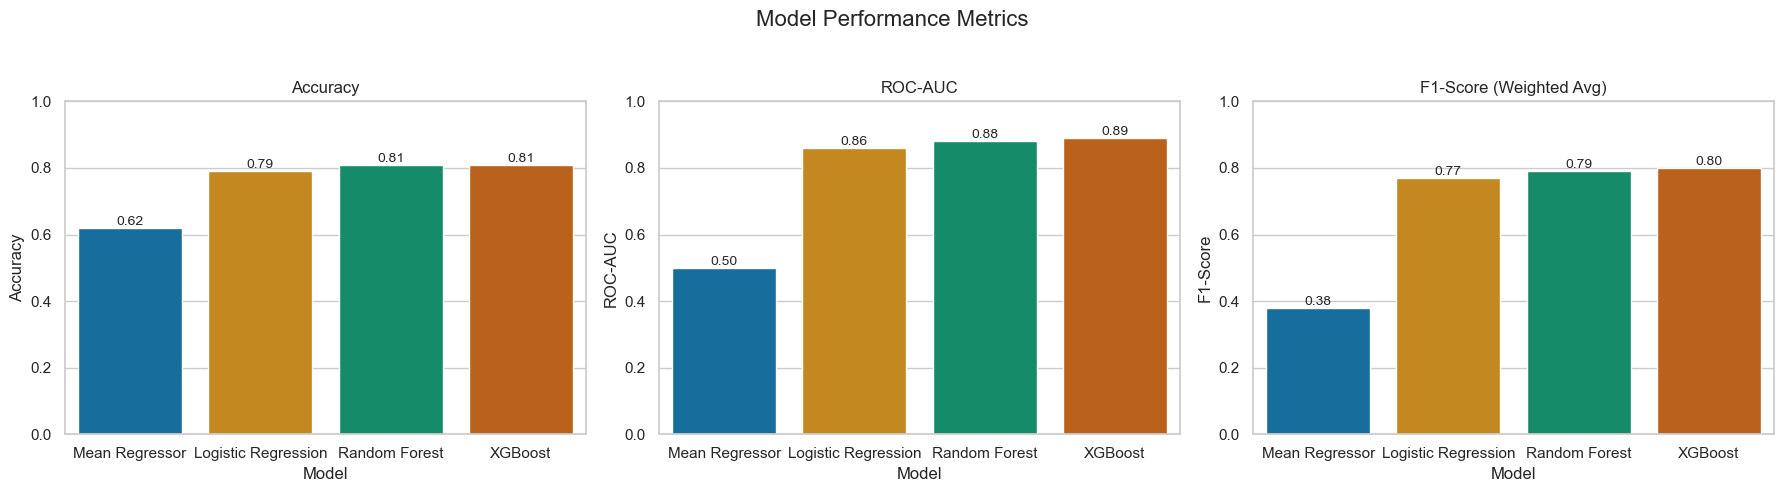


Final metrics data:
===================  ==========  =========  =========================
Model                  Accuracy    ROC-AUC    F1-Score (Weighted Avg)
===================  ==========  =========  =========================
Mean Regressor             0.62       0.5                        0.38
Logistic Regression        0.79       0.86                       0.77
Random Forest              0.81       0.88                       0.79
XGBoost                    0.81       0.89                       0.8
===================  ==========  =========  =========================


In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate  # Importing tabulate for formatted tables

# Rearrange the DataFrame to the desired order: Mean -> Logistic Regression -> Random Forest -> XGBoost
df_metrics = df_metrics.set_index('Model').reindex(['Mean Regressor', 'Logistic Regression', 'Random Forest', 'XGBoost']).reset_index()

# Ensure the F1-Score values are floats
df_metrics['F1-Score (Weighted Avg)'] = df_metrics['F1-Score (Weighted Avg)'].astype(float)

# Round the metrics to two decimal places
df_metrics = df_metrics.round(2)

# Create a figure with 1 row and 3 columns for the metrics plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Set the title of the figure
fig.suptitle('Model Performance Metrics', fontsize=16)

# Use a colorblind-friendly palette with the first four colors
color_palette = sns.color_palette("colorblind", n_colors=4)

# Plot Accuracy (vertical)
sns.barplot(x='Model', y='Accuracy', data=df_metrics, ax=axes[0], palette=color_palette, hue='Model', legend=False)
axes[0].set_title('Accuracy')
axes[0].set_ylim(0, 1)  # Set y-axis limit to 1 for accuracy
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Model')

# Annotate bars with their data values
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.2f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=10)

# Plot ROC-AUC (vertical)
sns.barplot(x='Model', y='ROC-AUC', data=df_metrics, ax=axes[1], palette=color_palette, hue='Model', legend=False)
axes[1].set_title('ROC-AUC')
axes[1].set_ylim(0, 1)  # Set y-axis limit to 1 for ROC-AUC
axes[1].set_ylabel('ROC-AUC')
axes[1].set_xlabel('Model')

# Annotate bars with their data values
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.2f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=10)

# Plot F1-Score (vertical)
sns.barplot(x='Model', y='F1-Score (Weighted Avg)', data=df_metrics, ax=axes[2], palette=color_palette, hue='Model', legend=False)
axes[2].set_title('F1-Score (Weighted Avg)')
axes[2].set_ylim(0, 1)  # Set y-axis limit to 1 for F1-Score
axes[2].set_ylabel('F1-Score')
axes[2].set_xlabel('Model')

# Annotate bars with their data values
for p in axes[2].patches:
    axes[2].annotate(f'{p.get_height():.2f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the title position

# Show the plots
plt.show()

# Print the final metrics data with two decimal places in a formatted table
print("\nFinal metrics data:")
print(tabulate(df_metrics, headers='keys', tablefmt='rst', showindex=False))

Choose XGBoost as primary model with the highest Accuracy. 

# Model Interpretation for Ultimate

Creating SHAP Explainer...
Calculating SHAP values...


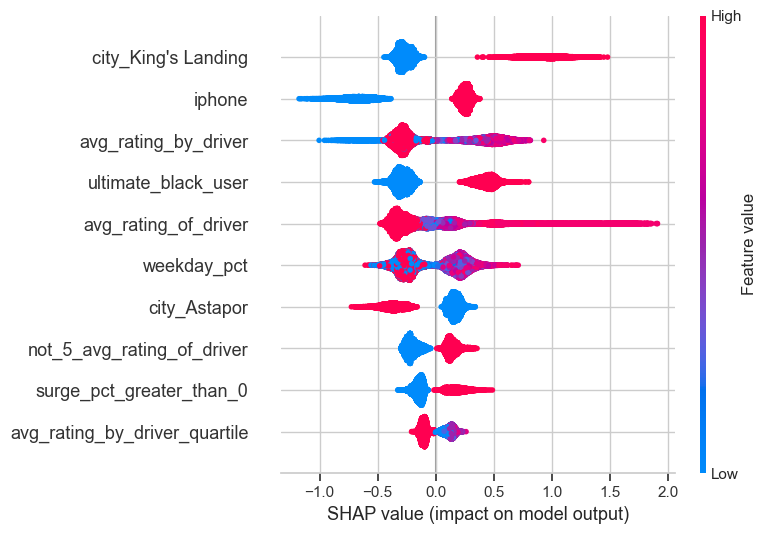

In [73]:
# Create a SHAP explainer using the trained model
print("Creating SHAP Explainer...")
explainer = shap.Explainer(best_xgb_model)

# Calculate SHAP values using the scaled training data
print("Calculating SHAP values...")
shap_values = explainer(X_train_scaled)

# Get the feature names from the original DataFrame after one-hot encoding
feature_names = X_train.columns  # Use the original DataFrame column names

# Visualize the SHAP values with feature names, showing only the top 10 features
shap.summary_plot(shap_values, X_train_scaled, feature_names=feature_names, max_display=10)


Total instances predicted to be in the positive class: 14046
Total instances predicted to be in the negative class: 25954


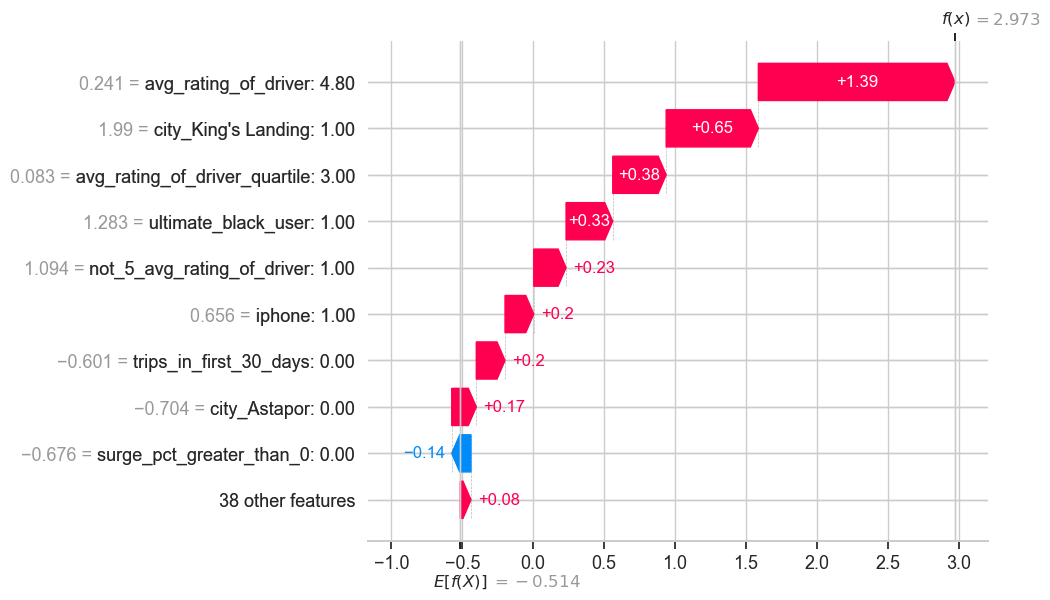

Probability of positive class for instance 0: 0.9513
Expected value (baseline prediction): -0.5138
SHAP values sum for instance 0: 3.4868
Final prediction for instance 0: 2.9730


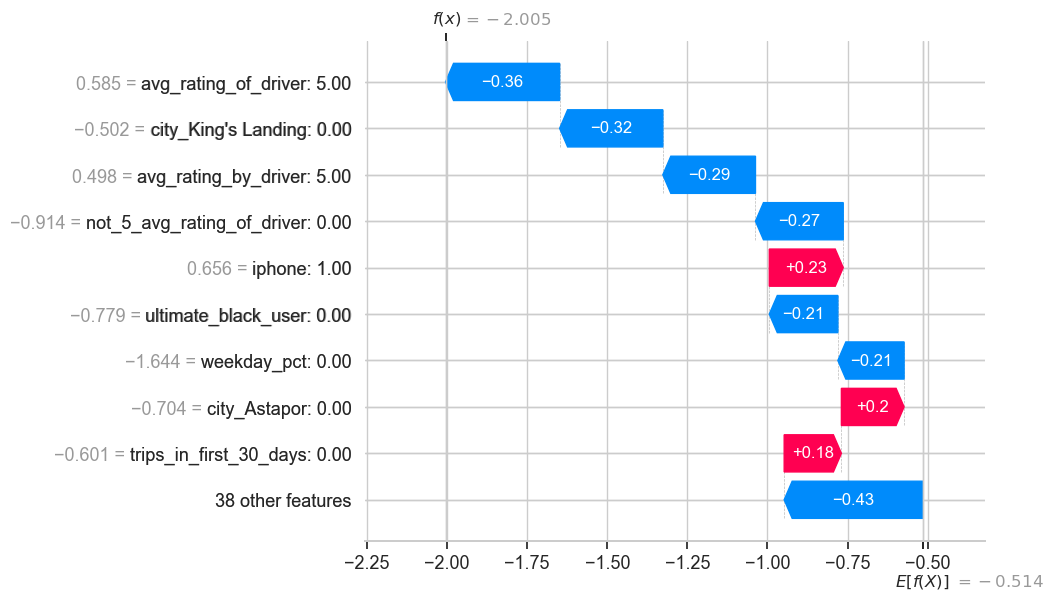

Probability of positive class for instance 1: 0.1187
Expected value (baseline prediction): -0.5138
SHAP values sum for instance 1: -1.4913
Final prediction for instance 1: -2.0051


In [70]:
# Get the predicted probabilities for the positive class using scaled training data
probabilities = best_xgb_model.predict_proba(X_train_scaled)  # Use the scaled training data

# Create arrays to store instances that are predicted as positive and negative
positive_instances = []
negative_instances = []

# Loop through the probabilities to find positive and negative class instances
for instance_index in range(len(probabilities)):
    if probabilities[instance_index, 1] > 0.5:  # Assuming a threshold of 0.5 for positive class
        positive_instances.append(instance_index)
    else:
        negative_instances.append(instance_index)

# Count the number of positive and negative instances
positive_count = len(positive_instances)
negative_count = len(negative_instances)

# Display the number of positive and negative instances
print(f"Total instances predicted to be in the positive class: {positive_count}")
print(f"Total instances predicted to be in the negative class: {negative_count}")

# Get feature names from the original DataFrame after one-hot encoding
feature_names = X_train.columns.tolist()  # Use .tolist() to convert to a list

# Example: Visualizing the SHAP values for the first positive instance
if positive_instances:
    first_positive_index = positive_instances[0]  # Get the first positive instance
    instance_shap_values = shap_values[first_positive_index]  # Use the shap values calculated from scaled data

    # Get the original feature values for the specific instance
    instance_values = X_train.iloc[first_positive_index]  # Use original, unscaled data

    # Create custom feature labels with unscaled values
    custom_feature_labels = [f"{name}: {value:.2f}" for name, value in zip(feature_names, instance_values)]

    # Set feature names for the SHAP values object
    instance_shap_values.feature_names = custom_feature_labels

    # Create the waterfall plot for the first positive instance
    shap.waterfall_plot(instance_shap_values)

    # Get the expected value of the model (baseline prediction)
    expected_value = explainer.expected_value

    # Calculate the final prediction by summing the expected value and SHAP values
    final_prediction = expected_value + instance_shap_values.values.sum()

    # Print the results for the first positive instance
    print(f"Probability of positive class for instance {first_positive_index}: {probabilities[first_positive_index, 1]:.4f}")
    print(f"Expected value (baseline prediction): {expected_value:.4f}")
    print(f"SHAP values sum for instance {first_positive_index}: {instance_shap_values.values.sum():.4f}")
    print(f"Final prediction for instance {first_positive_index}: {final_prediction:.4f}")

# Example: Visualizing the SHAP values for the first negative instance
if negative_instances:
    first_negative_index = negative_instances[0]  # Get the first negative instance
    instance_shap_values_neg = shap_values[first_negative_index]  # Use the shap values calculated from scaled data

    # Get the original feature values for the specific instance
    instance_values_neg = X_train.iloc[first_negative_index]  # Use original, unscaled data

    # Create custom feature labels with unscaled values
    custom_feature_labels_neg = [f"{name}: {value:.2f}" for name, value in zip(feature_names, instance_values_neg)]

    # Set feature names for the SHAP values object
    instance_shap_values_neg.feature_names = custom_feature_labels_neg

    # Create the waterfall plot for the first negative instance
    shap.waterfall_plot(instance_shap_values_neg)

    # Get the expected value of the model (baseline prediction)
    expected_value = explainer.expected_value

    # Calculate the final prediction by summing the expected value and SHAP values
    final_prediction_neg = expected_value + instance_shap_values_neg.values.sum()

    # Print the results for the first negative instance
    print(f"Probability of positive class for instance {first_negative_index}: {probabilities[first_negative_index, 1]:.4f}")
    print(f"Expected value (baseline prediction): {expected_value:.4f}")
    print(f"SHAP values sum for instance {first_negative_index}: {instance_shap_values_neg.values.sum():.4f}")
    print(f"Final prediction for instance {first_negative_index}: {final_prediction_neg:.4f}")